# Multiscale Transfer

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2 as cv

from skimage.color import rgb2lab
from skimage.color import lab2rgb

import mediapipe as mp

## Common Funcs

In [2]:
def rescale(img):
    return (img - img.min()) / (img.max() - img.min())


def rescale_L(img):
    return (img - img.min()) * 100 / (img.max() - img.min())

def rescale_a(img):
    return -127.0 + (img - img.min()) * (2 * 127.0) / (img.max() - img.min())

def rescale_b(img):
    return -124.0 + (img - img.min()) * (2 * 127.0) / (img.max() - img.min())

In [3]:
## Loading images with integer value intensities, range(0-255)
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1]
    
    img = rescale(img)
    return img

def load_lab(path):
    img = cv.imread(path)
    # img = cv.cvtColor(img, cv.COLOR_BGR2LAB) 
    
    img = img[..., ::-1]
    img = rgb2lab(img)
    
    img = rescale(img)
    return img

def load_gray(path):
    img = cv.imread(path, 0)
    
    img = rescale(img)
    return img

In [4]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    # img = rescale(img)
    plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:
        plt.imsave(f'../data/outs/{title}.png', img)
        
    plt.show()
    plt.close(fig)


def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    # img = rescale(img)
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../imgs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

## 1. Multiscale Decomposition 

This step involves to decompose the input and example images into multiscale Laplacian stacks. <br>
Input image: I, example image: E <br>
Using a 2D normalized Gaussian kernel G($\sigma$) <br>

$$ L_l[I] = \left\{
    \begin{array}{ll} I - I \space ⊗ \space G(2) & if \space l = 0 \\ I \space ⊗\space G(2^l) - I\space ⊗ \space G(2^{l+1}) & if \space l > 0 \end{array} \right\}
$$

For a stack with $ n >= 0 $ levels, residual is defined as: -
$$ R[I] = I \space ⊗ \space G(2^n) $$ 

In [5]:
def laplacian_stacks(img, n=6):
    img = img.copy()
    # img = (img - np.min()) / (np.max(img) - np.max(img))
    
    laplacian_stacks = [rescale(img)]
    
    sigma = 1
    for i in range(n+1):
        sigma <<= 1
        k = 5 * sigma + 1
        
        gauss_blur = cv.GaussianBlur(img, (k, k), sigma)
        laplacian_stacks.append(gauss_blur)
    
    for i in range(n+1):
        # laplacian_stacks[i] = rescale(cv.subtract(laplacian_stacks[i+1], laplacian_stacks[i]))
        # laplacian_stacks[i] = rescale(cv.subtract(laplacian_stacks[i], laplacian_stacks[i+1]))
        
        laplacian_stacks[i] = rescale(laplacian_stacks[i] - laplacian_stacks[i+1])
        # laplacian_stacks[i] = laplacian_stacks[i] - laplacian_stacks[i+1]
    
    laplacian_stacks = np.array(laplacian_stacks)
    
    # return laplacian_stacks[1:-1], residuals[1:]
    return laplacian_stacks[:-1]

In [6]:
def residual(img, n=6):
    img = img.copy()
    
    sigma = 2 ** n
    k = 5 * sigma + 1
    
    R = cv.GaussianBlur(img, (k, k), sigma)
    return R

In [7]:
style_lab = load_lab('../data/inputs/example_2.png')
input_lab = load_lab('../data/inputs/input_2.png')

L_style, a_style, b_style = cv.split(style_lab)
L_input, a_input, b_input = cv.split(input_lab)

In [8]:
style_rgb = load_rgb('../data/inputs/example_2.png')
input_rgb = load_rgb('../data/inputs/input_2.png')

R_style, G_style, B_style = cv.split(style_rgb)
R_input, G_input, B_input = cv.split(input_rgb)

In [9]:
n = 6

## L channel
L_style_stacks = laplacian_stacks(L_style, n)
L_style_residual = residual(L_style, n)

L_input_stacks = laplacian_stacks(L_input, n)
L_input_residual = residual(L_input, n)

## a channel
a_style_stacks = laplacian_stacks(a_style, n)
a_style_residual = residual(a_style, n)

a_input_stacks = laplacian_stacks(a_input, n)
a_input_residual = residual(a_input, n)

## b channel
b_style_stacks = laplacian_stacks(b_style, n)
b_style_residual = residual(b_style, n)

b_input_stacks = laplacian_stacks(b_input, n)
b_input_residual = residual(b_input, n)

In [10]:
## RGB channel

rgb_style_stacks = laplacian_stacks(style_rgb, n)
rgb_style_residual = residual(style_rgb, n)

rgb_input_stacks = laplacian_stacks(input_rgb, n)
rgb_input_residual = residual(input_rgb, n)

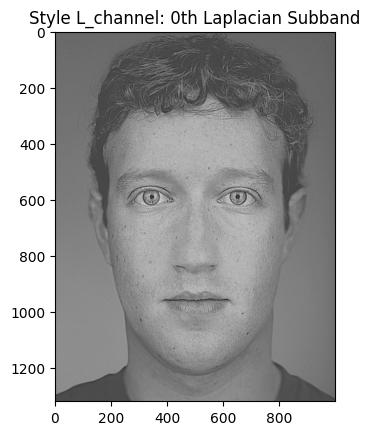

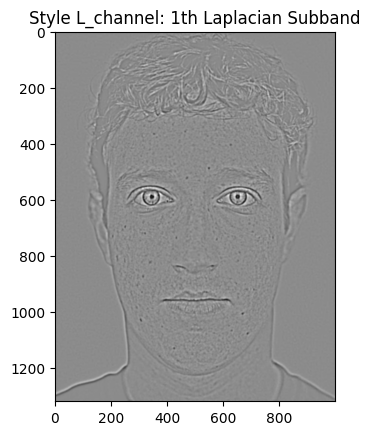

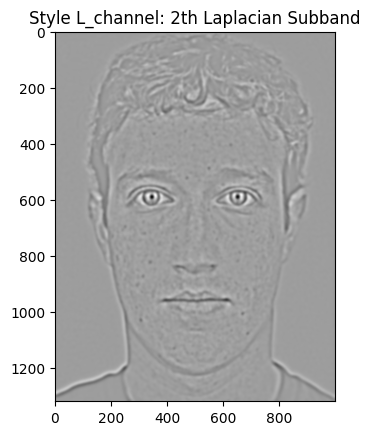

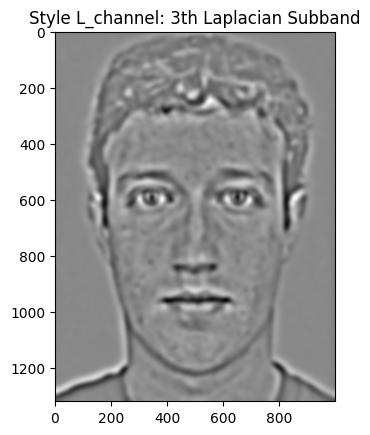

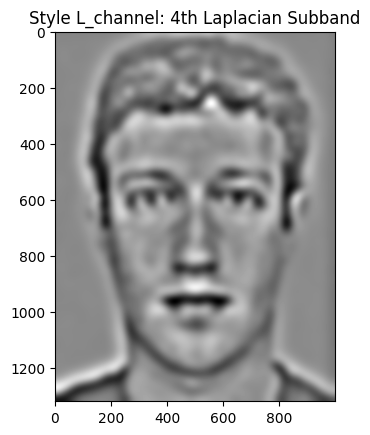

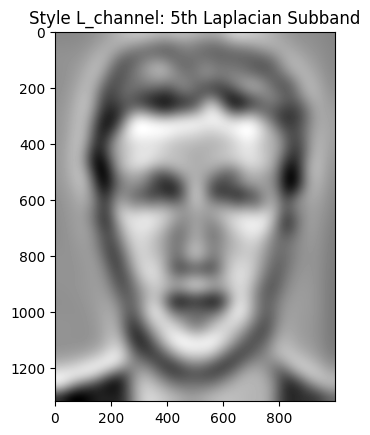

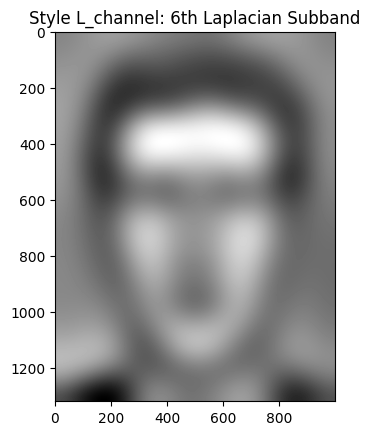

In [11]:
for i in range(n+1):
    plot_grayscale(L_style_stacks[i], title=f'Style L_channel: {i}th Laplacian Subband')

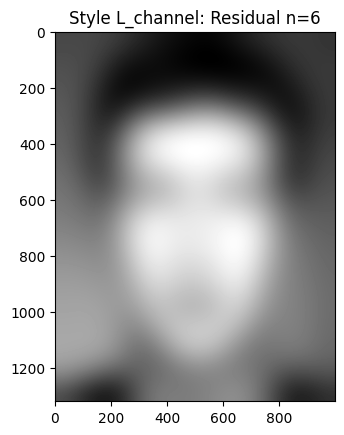

In [12]:
plot_grayscale(L_style_residual, title=f'Style L_channel: Residual n={n}')

## 2. Local Energy 

- $ S_l[I] = L_l^2[I] \space ⊗ \space G(2^{l+1}) $

In [13]:
#local enery 
def local_energy(laplacian_stacks):
    S = []
    sigma = 1
    
    for subband in laplacian_stacks:
        sigma <<= 1
        k = 5 * sigma + 1
        
        # S.append(rescale(cv.GaussianBlur(subband ** 2, (k, k), sigma)))
        S.append(cv.GaussianBlur(subband ** 2, (k, k), sigma))
        
    return np.array(S)

In [14]:
## L channel
L_style_energy = local_energy(L_style_stacks)
L_input_energy = local_energy(L_input_stacks)

## a channel
a_style_energy = local_energy(a_style_stacks)
a_input_energy = local_energy(a_input_stacks)

## b channel
b_style_energy = local_energy(b_style_stacks)
b_input_energy = local_energy(b_input_stacks)

In [15]:
## RGB channel

rgb_style_energy = local_energy(rgb_style_stacks)
rgb_input_energy = local_energy(rgb_input_stacks)

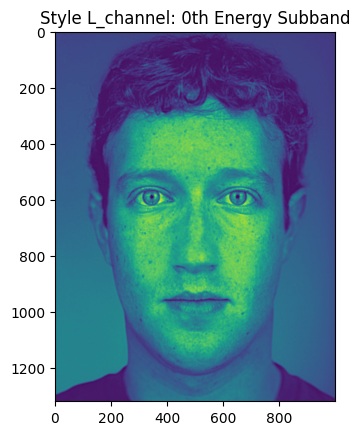

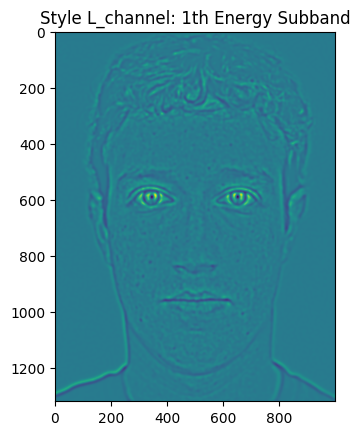

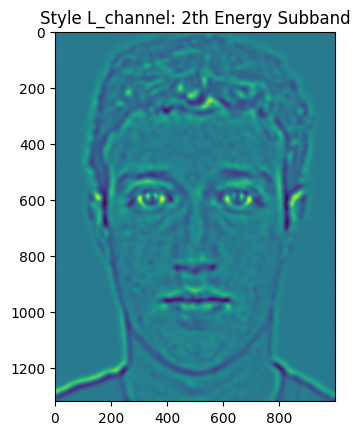

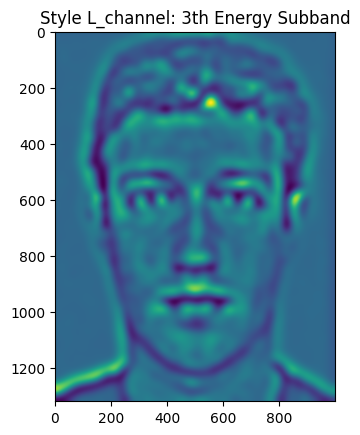

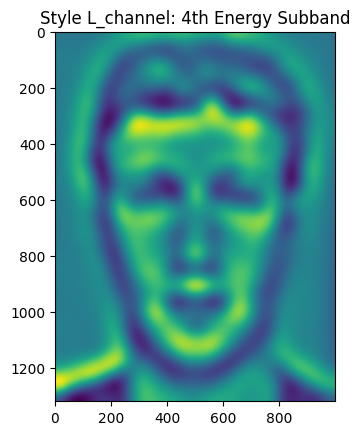

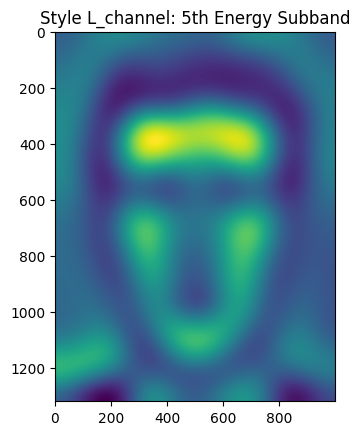

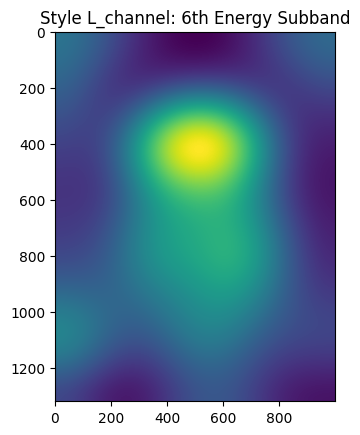

In [16]:
for i in range(n+1):
    plot_rgb(L_style_energy[i], title=f'Style L_channel: {i}th Energy Subband')

### Dense Correspondence and Getting The Warping Operator (W)

- We will first apply the Dense Correspondence to get Warped image of style according to input
- Use that Warping Operator (W) to warp energy maps too

In [17]:
style_rgb = np.array(load_rgb('../data/inputs/example_2.png'), dtype='float32')
input_rgb = np.array(load_rgb('../data/inputs/input_2.png'), dtype='float32')

In [18]:
style_gray = np.uint8(np.round((load_gray('../data/inputs/example_2.png') * 255)))
input_gray = np.uint8(np.round((load_gray('../data/inputs/input_2.png') * 255)))

In [19]:
# style_landmarks = np.array(pd.read_csv('../data/inputs/example_2.lm', header=None),dtype='float32')
# input_landmarks = np.array(pd.read_csv('../data/inputs/input_2.lm', header=None),dtype='float32')

In [20]:
## Import this landmark detector

!wget -nc https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat -O ../data/inputs/shape_predictor_68_face_landmarks.dat

File ‘../data/inputs/shape_predictor_68_face_landmarks.dat’ already there; not retrieving.


In [21]:
from dlib_landmarks import face_landmarks

style_landmarks = np.array(face_landmarks(style_gray),dtype='float32')
input_landmarks = np.array(face_landmarks(input_gray),dtype='float32')

In [22]:
from warp import warp_style

# ## Wrap function
warp_img, xx, yy, vx, vy = warp_style(style_img=style_rgb, input_img=input_rgb,style_lm=style_landmarks,input_lm=input_landmarks)
warp_img = rescale(warp_img)

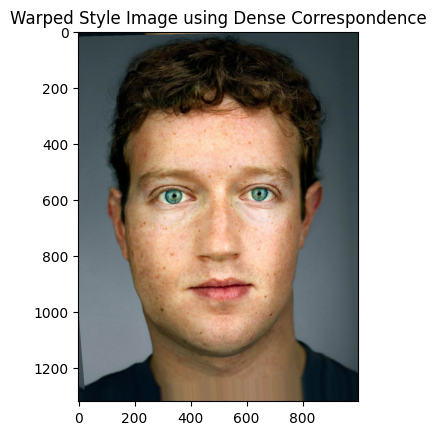

In [23]:
plot_rgb(warp_img, title='Warped Style Image using Dense Correspondence')

### 3. Warping Stacks and Residues

- $S̃_ℓ [E] = W (S_ℓ [E])$
- $R[O] = W (R[E])$

In [24]:
def warp_stacks(energy_stacks, xx, yy, vx, vy):
    warp_energy = []
    for subband in energy_stacks:
        temp = np.ones(subband.shape)
        temp[yy, xx] = subband[vy, vx]
        
        warp_energy.append(temp)
    
    return np.array(warp_energy)

In [25]:
def warp_residual(residual, xx, yy, vx, vy):
    warp_residual = np.ones(residual.shape)
    warp_residual[yy, xx] = residual[vy, vx]
    
    return warp_residual

In [26]:
## L channel
L_warp_style_energy = warp_stacks(L_style_stacks, xx, yy, vx, vy)
L_warp_style_residual = warp_residual(L_style_residual, xx, yy, vx, vy)

## a channel
a_warp_style_energy = warp_stacks(a_style_stacks, xx, yy, vx, vy)
a_warp_style_residual = warp_residual(a_style_residual, xx, yy, vx, vy)

## b channel
b_warp_style_energy = warp_stacks(b_style_stacks, xx, yy, vx, vy)
b_warp_style_residual = warp_residual(b_style_residual, xx, yy, vx, vy)

In [27]:
## rgb channel

rgb_warp_style_energy = np.zeros(rgb_style_stacks.shape)

rgb_warp_style_energy[..., 0] = warp_stacks(rgb_style_stacks[..., 0], xx, yy, vx, vy)
rgb_warp_style_energy[..., 1] = warp_stacks(rgb_style_stacks[..., 1], xx, yy, vx, vy)
rgb_warp_style_energy[..., 2] = warp_stacks(rgb_style_stacks[..., 2], xx, yy, vx, vy)

rgb_warp_style_residual = np.zeros(rgb_style_residual.shape)

rgb_warp_style_residual[..., 0] = warp_residual(rgb_style_residual[..., 0], xx, yy, vx, vy)
rgb_warp_style_residual[..., 1] = warp_residual(rgb_style_residual[..., 1], xx, yy, vx, vy)
rgb_warp_style_residual[..., 2] = warp_residual(rgb_style_residual[..., 2], xx, yy, vx, vy)

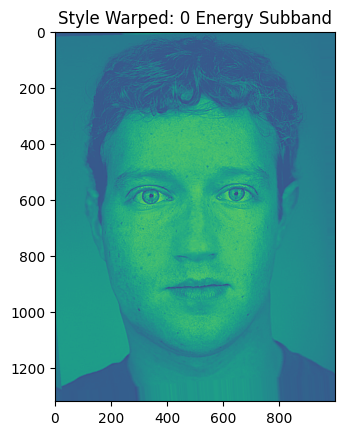

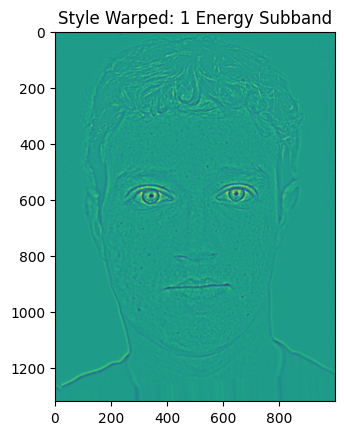

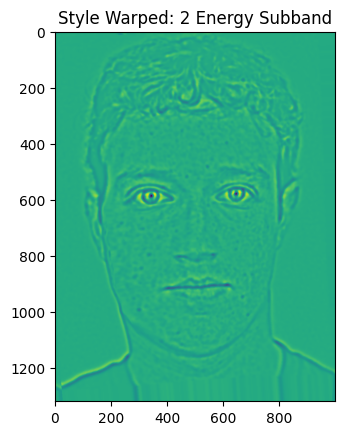

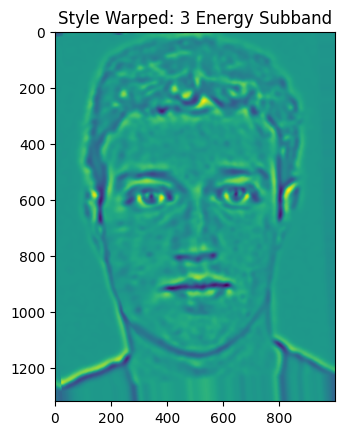

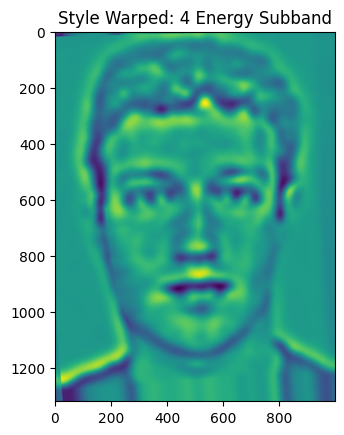

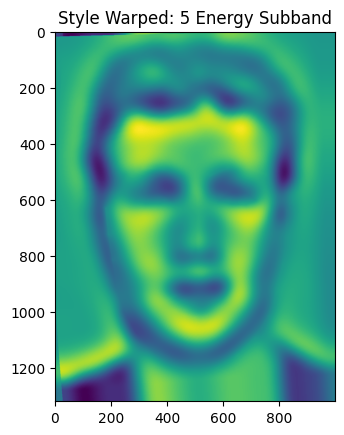

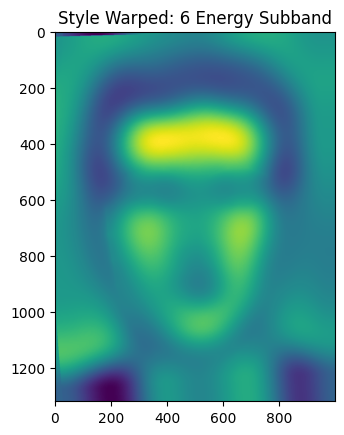

In [28]:
for i in range(n+1):
    plot_rgb(L_warp_style_energy[i], title=f'Style Warped: {i} Energy Subband')

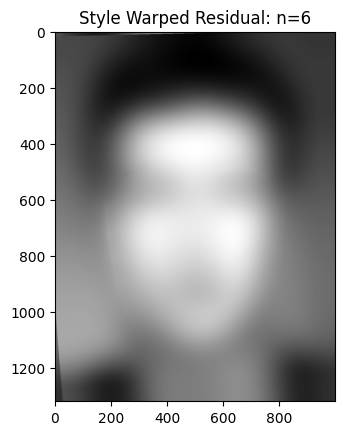

In [29]:
plot_grayscale(L_warp_style_residual, title=f'Style Warped Residual: n={n}')

## 4. Robust Transfer

- $\text{RobustGain} = \max(\min(\text{Gain}, θh ), θl ) ⊗ G(β 2^ℓ )$
- $L_ℓ [O] = L_ℓ [I] × \text{RobustGain}$

In [30]:
def gain(warp_style_energy, input_energy):
    e = (1e-2) ** 2.0
    G = np.sqrt(warp_style_energy/(input_energy + e))
    return G

In [31]:
def robust_gain(warp_style_energy, input_energy, theta_h=2.8, theta_l=0.9, beta=3):
    G = gain(warp_style_energy, input_energy)
    RG = []
    
    sigma = 1
    for subband in G:
        k = 2 * (beta * sigma) + 1
        
        subband[subband > theta_h] = theta_h
        subband[subband < theta_l] = theta_l
        
        r_subband = cv.GaussianBlur(subband, (k, k), beta * sigma)
        RG.append(r_subband)
        
        sigma <<= 1
        
    return np.array(RG)

In [32]:
def robust_transfer(input_laplacian_stacks, warp_style_energy, input_energy):
    theta_h=2.8
    theta_l=0.9
    beta=3
    
    RG = robust_gain(warp_style_energy, input_energy, theta_h = theta_h, theta_l = theta_l, beta = beta)
    output_laplacian_stacks = input_laplacian_stacks * RG
    
    return output_laplacian_stacks

In [33]:
## L channel
L_output_stacks = robust_transfer(L_input_stacks, L_warp_style_energy, L_input_energy)

## a channel
a_output_stacks = robust_transfer(a_input_stacks, a_warp_style_energy, a_input_energy)

## b channel
b_output_stacks = robust_transfer(b_input_stacks, b_warp_style_energy, b_input_energy)

In [34]:
## RGB channel
rgb_output_stacks = robust_transfer(rgb_input_stacks, rgb_warp_style_energy, rgb_input_energy)

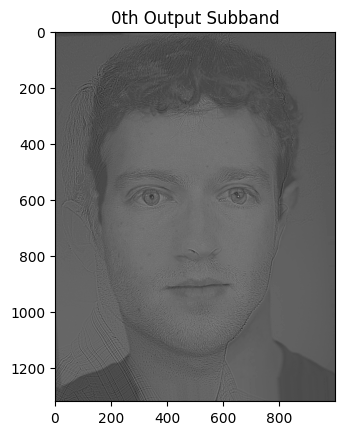

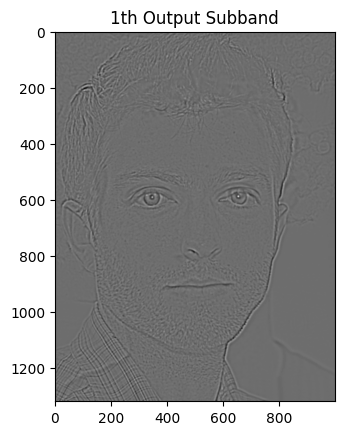

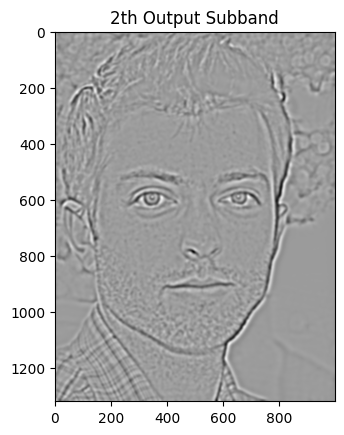

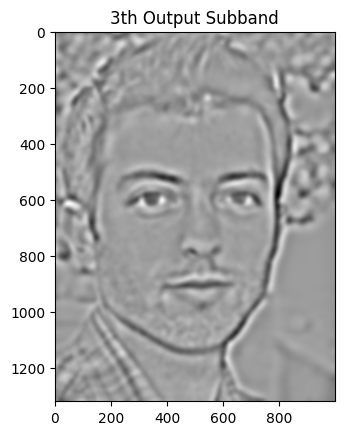

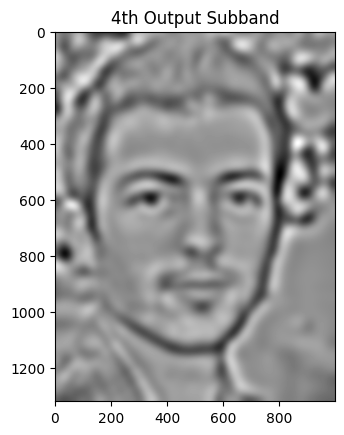

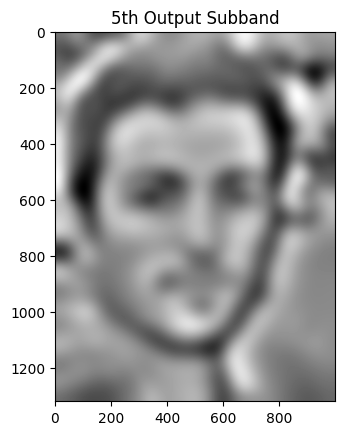

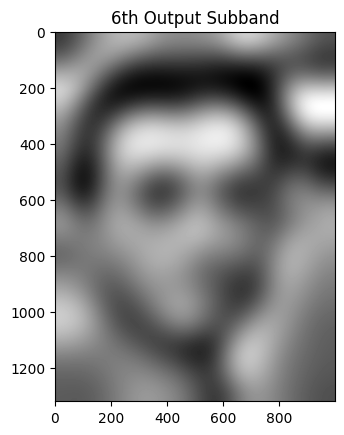

In [35]:
for i in range(n+1):
    plot_grayscale(L_output_stacks[i], title=f'{i}th Output Subband')

## 5. Aggregate Output Stack

- Adding all the Laplacian Stacks and Residual for each channel
- Converting the Output Channels from $Lab$ colorspace to $RGB$ colorspace
- Also shown the Output of strictly performing this algorithm on $RGB$ space

In [36]:
def aggregate_stacks(output_stacks, warp_style_residual):
    output = rescale(np.sum(output_stacks, axis=0) + warp_style_residual)
    return output

In [37]:
## L channel
# L_output = rescale_L(aggregate_stacks(L_output_stacks, L_warp_style_residual))
L_output = aggregate_stacks(L_output_stacks[1:], L_warp_style_residual)

## a channel
# a_output = rescale_a(aggregate_stacks(a_output_stacks, a_warp_style_residual))
a_output = aggregate_stacks(a_output_stacks[3:], a_warp_style_residual)

## b channel
# b_output = rescale_b(aggregate_stacks(b_output_stacks, b_warp_style_residual))
b_output = aggregate_stacks(b_output_stacks[3:], b_warp_style_residual)

In [38]:
## RGB channel
rgb_output = aggregate_stacks(rgb_output_stacks[1:], rgb_warp_style_residual)

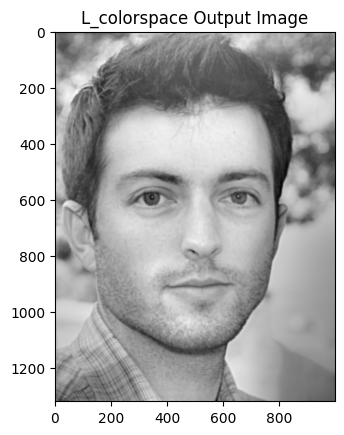

In [39]:
plot_grayscale(L_output, title='L_colorspace Output Image')

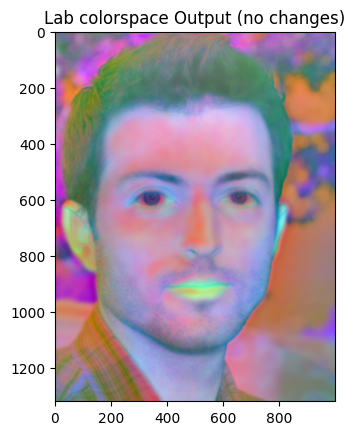

In [40]:
## Output Image in LAB color space

lab_output = np.dstack([L_output, a_output, b_output])
plot_rgb(lab_output, title=f'Lab colorspace Output (no changes)')

In [41]:
## Not working

# output_img = cv.cvtColor(output_img, cv.COLOR_LAB2RGB)
# plot_rgb(output_img)

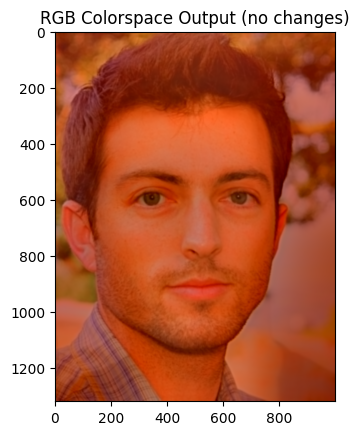

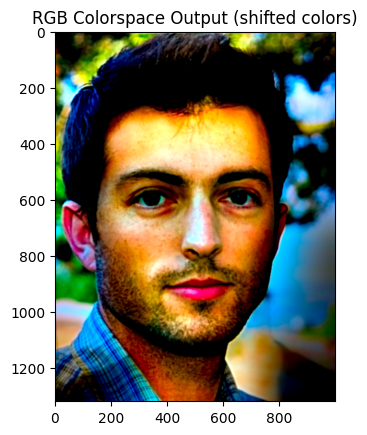

In [43]:
## Output image in RGB colorspace

output_rgb1 = lab2rgb(lab_output)
plot_rgb(rescale(output_rgb1), title=f'RGB Colorspace Output (no changes)')

output_rgb2 = lab2rgb(lab_output * 255 - 128)
plot_rgb(rescale(output_rgb2), title=f'RGB Colorspace Output (shifted colors)')

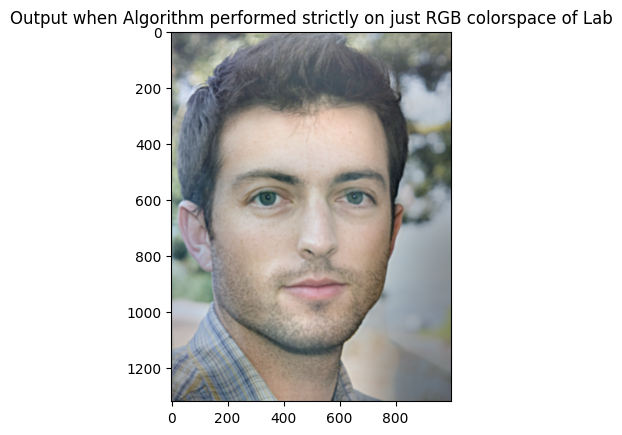

In [44]:
## RGB Transformation output
plot_rgb(rgb_output, title=f'Output when Algorithm performed strictly on just RGB colorspace of Lab')

## 6. Background

**Image Implanting**:

- Image inpainting is the process of removing damage, such as noises, strokes or text, on images. It is particularly useful in the restoration of old photographs which might have scratched edges or ink spots on them. 

- An Image Inpainting Technique Based on the Fast Marching Method, Alexandru Telea, 2004:
    - This is based on Fast Marching Method (FMM). Looking at the region to be inpainted, the algorithm first starts with the boundary pixels and then goes to the pixels inside the boundary.
    - It replaces each pixel to be inpainted with a weighted sum of the pixels in the background, with more weight given to nearer pixels and boundary pixels.

- Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting”, Bertalmio, Marcelo, Andrea L. Bertozzi, and Guillermo Sapiro, 2001:
    - This algorithm is inspired by partial differential equations. Starting from the edges (known regions) towards the unknown regions, it propagates isophote lines (lines that join same-intensity points). 
    - Finally, variance in an area is minimized to fill colors.
    
- FMM can be invoked by using cv2.INPAINT_TELEA, while Navier-Stokes can be invoked using cv2.INPAINT_NS

In [45]:
def get_mask(img):
    results = selfie_segmentation.process(img)
    mask = results.segmentation_mask
    mask = np.where(mask > 0.0005 , 1, 0)
    return mask

def getBackground(image, mask):
    img = image.copy()
    img[mask > 0 ] = [0, 0, 0]
    return img

def change_baground(image, mask, background):
    img = image.copy()
    img[mask == 0 ] = background[mask == 0 ]
    return img

def imperfection_mask(img,mask):
    new_img = np.zeros((img.shape[0], img.shape[1]))
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)+mask
   
    new_img[gray<=0] = 255
    new_img[gray>0]=0
    return np.uint8(new_img)


def exchange_baground(input_rgb,output_rgb,example_rgb):
    # plot_rgb(input_rgb)
    # plot_rgb(example_rgb)
    
    mask_input = get_mask(input_rgb)
    mask_example = get_mask(example_rgb)
    
    # plot_grayscale(mask_input)
    #print(mask_input)
    # plot_grayscale(mask_example)
    
    bag = getBackground(example_rgb, mask_example)
    # plot_rgb(bag)
    
    new_img = change_baground(output_rgb, mask_input, bag)
    # plot_rgb(new_img)
    
    mask_imperect = imperfection_mask(new_img,mask_input)
    # plot_grayscale(mask_imperect)
    
    final_baground_change = cv.inpaint(new_img, mask_imperect, 3, cv.INPAINT_NS)
    
    return final_baground_change


In [46]:
# initialize mediapipe
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

output_img = np.uint8(np.round(rescale(output_rgb2) * 255))
output_bg = exchange_baground(np.uint8(np.round(input_rgb * 255)), output_img, np.uint8(np.round(style_rgb * 255) ))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


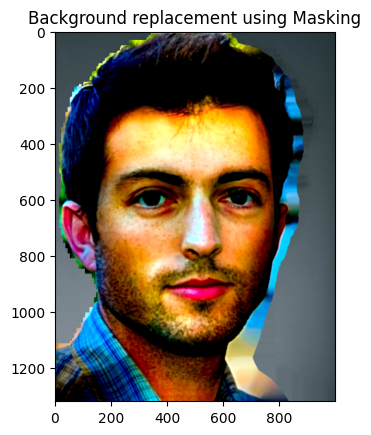

In [47]:
plot_rgb(output_bg, title=f'Background replacement using Masking')